# Практика 4 - Расчет характеристик модуля

Теперь, когда известно, как получить освещенность поверхности панелей (POA) и температуру фотоэлектрического модуля, давайте рассчитаем характеристики фотоэлектрического модуля, предполагая подмножество условий освещенности и температуры, предусмотренных нормативными документами.
С этой целью необходимо выполнить следующие задачи с использованием pvlib:

- выгрузить параметры фотоэлектрического модуля из последней библиотеки NREL System Advisor Model (SAM).
- рассчитать параметры модели с одним диодом (SDM) при стандартных условиях испытаний (STC) и наборе условий испытаний фотоэлектрических модулей, описанных в IEC 61853.
- сформировать ВАХ для каждого из условий испытаний в стандарте IEC 61853.
- получите параметры модели Калифорнийской энергетической комиссии (CEC) на основе стандартных тестовых измерений CEC.

<strong>Термины:</strong>
- Параметры STC (Standard test conditions)
- Вольт-амперные характеристики (ВАХ) - IV Curve
- Модели преобразования энергии фотоэлектрических модулей
- точечные модели
   -  [PVWatts](https://pvwatts.nrel.gov/)
   -  [Sandia Array Performance Model (SAPM)](https://energy.sandia.gov/wp-content/gallery/uploads/043535.pdf)
- непрерывные модели
   -  CEC
   -  [PVSyst](https://www.pvsyst.com/)
   -  [DeSoto](https://doi.org/10.1016/j.solener.2005.06.010)
   - производительность модуля при слабом освещении и температурные характеристики модуля
   - [IEC 61853 Photovoltaic (PV) module performance testing and energy rating - Part 1: Irradiance and temperature performance measurements and power rating](https://webstore.iec.ch/publication/6035)
      - [Русский стандарт](https://meganorm.ru/Data2/1/4293773/4293773868.pdf)

<strong>Основные понятия Python:</strong>
- [numpy.meshgrid](https://pvsc-python-tutorials.github.io/PVSC48-Python-Tutorial/Tutorial%204%20-%20Model%20a%20Module%27s%20Performance.html#:~:text=Python%20Concepts%3A-,numpy.meshgrid,-try%3A%20except)
- <code> try: except </code>
- транспонирование датафрейма pandas
- pandas методы индексирования строк: <code> df.index.str.startswith('Canadian') </code> где df датафрейм с моделям солнечных панелей

## 1. Стандартные условия для тестирования панелей (Standard Test Conditions (STC))
Базовые условия испытания панелей называются «Standard Test Conditions (STC)»
и считаются эталоном для большинства фотоэлектрических модулей.
Например, мощность фотоэлектрических модулей в базе данных модулей SAM CEC указана в STC.
<ul>
<li>излучение: 1000 Вт/м²</li>
<li>температура ячейки: 25°C</li>
<li>угол падения света (AOI): 0°</li>
<li>спектр: AM1.5g (ASTM G-173)</li></ul>

### Air mass (AM)
Стандартное значение AM1.5g (ASTM G-173) определяется как солнечный спектр глобального излучения, который проходит через 1,5 атмосферы.

### Условия испытаний согласно IEC 61853

Другим распространенным набором условий испытаний является стандарт IEC 61853, который предоставляет матрицу испытаний фотоэлектрических модулей,
которая охватывает ожидаемый диапазон исходного излучения и температуры ячеек для фотоэлектрических модулей при условии, что излучение нормальное, а солнечный спектр аналогичен AM1,5g.
<ul>
<li>освещенность (Вт/м²): 100, 200, 400, 600, 800, 1000, 1100</li>
<li>температура модуля (°C): 15, 25, 50, 75</li>
<li>угол падения: 0°</li>
<li>спектр: AM1.5g (ASTM G-173)</li>
</ul>

На рисунке ниже показаны результаты испытаний IEC 61853, проведенных в лабораториях CFV:

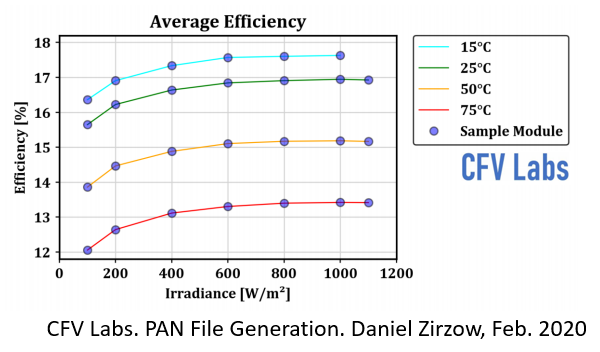

In [1]:
from IPython.display import Image
Image("D:\\OneDrive\\Документы\\GitHub\\URFU_SOLAR_ML\\Theme 2\\tutorials\\Images\\Pic3.png", width=400, height=200)

Некоторые комбинации исключены, поскольку они маловероятны: (1100 Вт/м², 15°C), (400 Вт/м², 75°C), (200 Вт/м², 50°C), (200 Вт/м², 50°C), (200 Вт/м², 50°C) /м², 75°C), (100 Вт/м², 50°C) и (100 Вт/м², 75°C).
На [рисунке](https://www.nrel.gov/docs/fy19osti/68637.pdf) ниже показаны параметры SAM, соответствующие результатам испытаний IEC61853 для двух различных технологий ячеек.
Белое пространство показывает комбинации освещенности и температуры, которые были намеренно исключены из тестирования.
$\alpha =  \frac{N_{cs}\cdot k \cdot T\cdot n}{q}$
$N_{cs}$ - количество ячеек в модуле
$k$ - постоянная Больцмана - 1.381 $\cdot$ $10^{-23}$ Дж/К
$T$ - температура ячейки (К)
$q$ - заряд электрона 1.602·$10^{-19}$ Кл
$n$ - коэффициент неидеальности диода

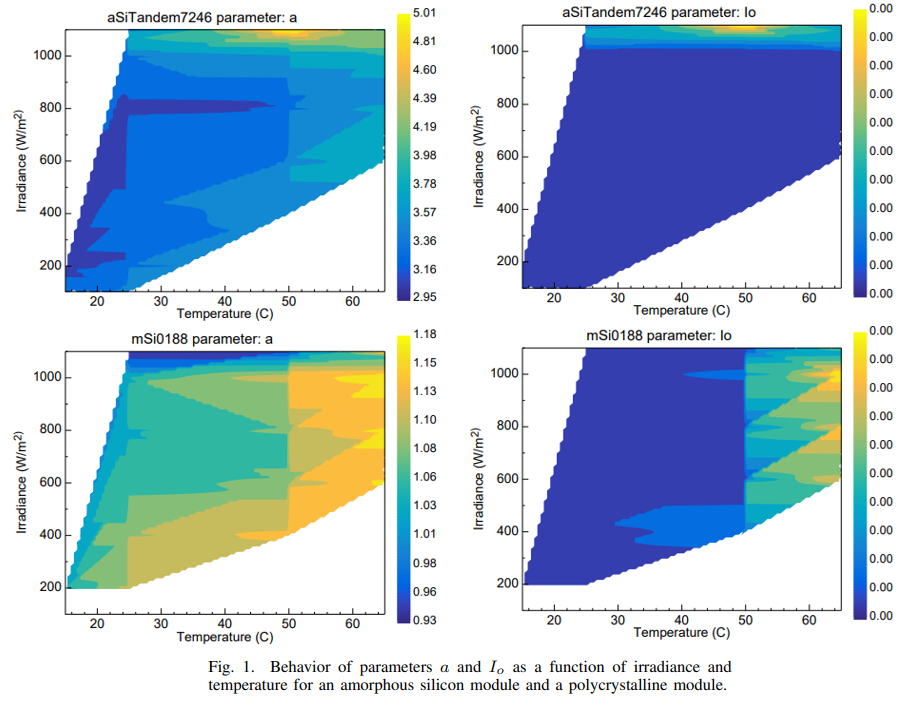

In [3]:
Image("D:\\OneDrive\\Документы\\GitHub\\URFU_SOLAR_ML\\Theme 2\\tutorials\\Images\\Pic4.png", width=400, height=200)

In [1]:
import pvlib
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
# Задание условий испытаний
E0 = 1000  # W/m^2
T0 = 25  # degC

# задание матрицы IEC61853
E_IEC61853 = [100, 200, 400, 600, 800, 1000, 1100]  # солнечная радиация [Вт/м^2]
T_IEC61853 = [15, 25, 50, 75]  # температура [degC]

# генерация meshgrid температур и солнечной радиации
# для всех 28 комбинаций
IEC61853 = np.meshgrid(T_IEC61853, E_IEC61853)

# функция meshgrid возвращает двухмерный массив (2-D) в том же порядке как и входные аргументы
# таким образом первый массив включает температуры,
# второй массив включает солнечную радиацию
# выведем температуру и солнечную радиацию для тестовых условий
IEC61853

[array([[15, 25, 50, 75],
        [15, 25, 50, 75],
        [15, 25, 50, 75],
        [15, 25, 50, 75],
        [15, 25, 50, 75],
        [15, 25, 50, 75],
        [15, 25, 50, 75]]),
 array([[ 100,  100,  100,  100],
        [ 200,  200,  200,  200],
        [ 400,  400,  400,  400],
        [ 600,  600,  600,  600],
        [ 800,  800,  800,  800],
        [1000, 1000, 1000, 1000],
        [1100, 1100, 1100, 1100]])]

## 2. Single Diode Model (SDM) & IV Curve
Производительность фотоэлектрического модуля может быть смоделирована с использованием точечных или непрерывных моделей ВАХ.

Точечные модели, такие как PVWatts и модель производительности массива Sandia (SAPM, также известная как модель Кинга), дают ток (I), напряжение (V) и мощность (P) в одной или нескольких точках.
PVWatts дает только производительность в точке максимальной мощности (MPP) модуля, тогда как SAPM также дает ток короткого замыкания (Isc), напряжение холостого хода (Voc).

Модели с непрерывной ВАХ, такие как модели CEC, PVsyst и DeSoto, позволяют построить ВАХ, охватывающие диапазон от Isc до Voc и далее.

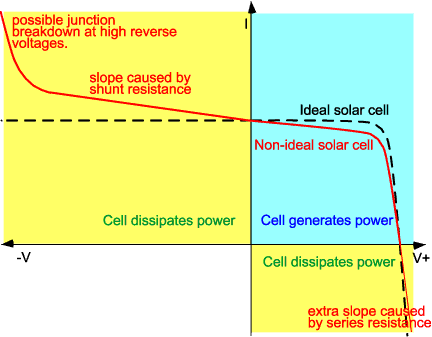

In [4]:
Image("D:\\OneDrive\\Документы\\GitHub\\URFU_SOLAR_ML\\Theme 2\\tutorials\\Images\\Pic5.png", width=400, height=200)

Соотношение ВАХ основано на «модели с одним диодом» или SDM, которая определяется 5 параметрами:
ток ячейки($I_L$), сопротивление шунта ($R_{sh}$), последовательное сопротивление ($R_s$), обратный ток и ток насыщения диода ($I_o$ и $I_{sat}$) и коэффициент неидеальности диода ($n$).
Другие символы для коэффициента идеальности диода: ($\gamma$) используется PVsyst и ($a$) используется SAM, ($\gamma$) используется для температурного коэффициента мощности.
Эта «идеальная» солнечная ячейка описывается приведенной ниже электрической схемой.

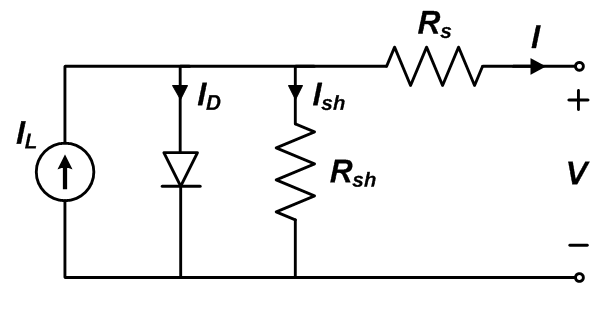

In [5]:
Image("D:\\OneDrive\\Документы\\GitHub\\URFU_SOLAR_ML\\Theme 2\\tutorials\\Images\\Pic6.png", width=400, height=200)

Combining the components in the SDM using Ohm’s and Kirchhoff’s laws yields the following equation, which is implicit because current (I) is on both sides of the equation, and cannot be solved explicitly:
$I = I_L - I_o \left( \exp \left( \frac{V + I R_s}{n V_T} \right) - 1 \right) - \frac{V + I R_s}{R_{sh}}$
with the diode voltage ($V_D = V + I R_s$), the diode current ($I_D$) given by the ideal diode equation:
$I_D = I_o \left( \exp \left( \frac{V_D}{n V_T} \right) - 1 \right)$
the thermal voltage ($V_T = k_T / q_e$), elementary charge ($q_e$), Boltzmann constant ($k_T$), and the shunt current ($I_{sh} = V_D / R_{sh}$)

## 3. CEC Model (aka SAM or 6-parameter model)

### pvlib python
Есть несколько функций, которые можно использовать в Python:
- <code>pvlib.pvsystem.retrieve_sam()</code>
- <code>pvlib.pvsystem.calcparams_cec()</code>
- <code>pvlib.pvsystem.singlediode()</code>
- <code>pvlib.ivtools.sdm.fit_cec_sam()</code>

In [4]:
pvlib.pvsystem.retrieve_sam?

In [5]:
# Позволяет получить параметры фотоэлектрических модулей CEC из библиотеки SAM
#  "CECMod - одобренные Clean Energy Counsil Australia "
CECMODS = pvlib.pvsystem.retrieve_sam(name='CECMod')

# Параметры модулей представлены в виде датафрейма pandas
# транспонируем представленный датафрейм
CECMODS.T.head()

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
A10Green_Technology_A10J_S72_175,Mono-c-Si,0,175.0914,151.2,1.3,1.576,0.825,72,5.17,43.99,...,1.981696,5.175703,0.0,0.316688,287.102203,16.057121,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_S72_180,Mono-c-Si,0,179.928,155.7,1.3,1.576,0.825,72,5.31,44.06,...,1.988414,5.316148,0.0,0.299919,259.047943,16.418983,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_S72_185,Mono-c-Si,0,184.7016,160.2,1.3,1.576,0.825,72,5.43,44.14,...,1.984817,5.435676,0.0,0.311962,298.424438,15.688233,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_M60_220,Multi-c-Si,0,219.876,189.1,1.624,1.632,0.995,60,7.95,36.06,...,1.673094,7.959062,0.0,0.140393,123.168404,21.875164,-0.5196,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_M60_225,Multi-c-Si,0,224.9856,193.5,1.624,1.632,0.995,60,8.04,36.24,...,1.671782,8.047206,0.0,0.14737,164.419479,20.698376,-0.5196,N,SAM 2018.11.11 r2,1/3/2019


In [6]:
CECMODS

,A10Green_Technology_A10J_S72_175,A10Green_Technology_A10J_S72_180,A10Green_Technology_A10J_S72_185,A10Green_Technology_A10J_M60_220,A10Green_Technology_A10J_M60_225,A10Green_Technology_A10J_M60_230,A10Green_Technology_A10J_M60_235,A10Green_Technology_A10J_M60_240,A2Peak_Power_POWER_ON_P220_6x10,Aavid_Solar_ASMS_165P,...,Zytech_Solar_ZT275P,Zytech_Solar_ZT280P,Zytech_Solar_ZT285P,Zytech_Solar_ZT290P,Zytech_Solar_ZT295P,Zytech_Solar_ZT300P,Zytech_Solar_ZT305P,Zytech_Solar_ZT310P,Zytech_Solar_ZT315P,Zytech_Solar_ZT320P
Technology,Mono-c-Si,Mono-c-Si,Mono-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,...,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si
Bifacial,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
STC,175.0914,179.928,184.7016,219.876,224.9856,230.1288,235.008,240.5376,219.978,164.85,...,275.0144,280.3294,285.326,290.0358,295.0656,300.0032,305.0564,310.1436,315.0936,320.42
PTC,151.2,155.7,160.2,189.1,193.5,204.1,208.7,213.3,195.0,146.3,...,248.0,252.6,257.3,261.9,266.5,271.2,275.8,280.5,285.1,289.8
A_c,1.3,1.3,1.3,1.624,1.624,1.624,1.624,1.624,1.633,1.301,...,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931
Length,1.576,1.576,1.576,1.632,1.632,1.632,1.632,1.632,1.633,1.575,...,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95
Width,0.825,0.825,0.825,0.995,0.995,0.995,0.995,0.995,1.0,0.826,...,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99
N_s,72,72,72,60,60,60,60,60,60,72,...,72,72,72,72,72,72,72,72,72,72
I_sc_ref,5.17,5.31,5.43,7.95,8.04,8.1,8.23,8.32,7.98,5.25,...,8.31,8.4,8.48,8.55,8.64,8.71,8.87,8.9,9.01,9.12
V_oc_ref,43.99,44.06,44.14,36.06,36.24,36.42,36.72,36.84,36.72,43.5,...,45.1,45.25,45.43,45.59,45.75,45.96,46.12,46.28,46.44,46.6


Описание некоторых параметров можно найти по [ссылке](https://www.nrel.gov/docs/fy18osti/67399.pdf).

In [5]:
CECMODS.T.keys()

Index(['Technology', 'Bifacial', 'STC', 'PTC', 'A_c', 'Length', 'Width', 'N_s',
       'I_sc_ref', 'V_oc_ref', 'I_mp_ref', 'V_mp_ref', 'alpha_sc', 'beta_oc',
       'T_NOCT', 'a_ref', 'I_L_ref', 'I_o_ref', 'R_s', 'R_sh_ref', 'Adjust',
       'gamma_r', 'BIPV', 'Version', 'Date'],
      dtype='object')

In [7]:
CECMODS.T['Technology'].unique()

array(['Mono-c-Si', 'Multi-c-Si', 'Thin Film', 'CdTe', 'CIGS'],
      dtype=object)

### CEC modules library

Периодически статическая копия параметров модуля CEC (California Energy Commission) копируется из библиотеки SAM в pvlib python. Модули условно названы по следующей схеме:
```
<manufacturer name> <model name>
```

Пробелы, тире и другие не буквенно-цифровые символы заменяются символами подчеркивания в pvlib python.
Например “Canadian Solar Inc. CS6X-300M” становится:
```
Canadian_Solar_Inc__CS6X_300M
```
Параметры солнечный панелей представлены [здесь](https://www.ecodirect.com/Canadian-Solar-CS6X-300M-300W-36V-PV-Panel-p/canadian-solar-cs6x-300m.htm>)

Основные параметры панелей представлены ниже:



In [8]:
# Можно найти нужный модуль используя строковые фильтры str
# Например: найдем все панели Candian Solar 220-W монокристаллические
cs_220m_mods = CECMODS.T.index.str.startswith('Canadian_Solar') & CECMODS.T.index.str.contains('220M')
CECMODS.T[cs_220m_mods]

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
Canadian_Solar_Inc__CS5P_220M,Mono-c-Si,0,219.961,200.1,1.7,1.602,1.061,96,5.1,59.4,...,2.635926,5.11426,0.0,1.066023,381.254425,8.619516,-0.476,N,SAM 2018.11.11 r2,1/3/2019
Canadian_Solar_Inc__CS6P_220M,Mono-c-Si,0,219.775,198.5,1.549,1.615,0.959,60,7.97,36.9,...,1.515583,7.980784,0.0,0.397651,293.871094,-3.311191,-0.436,N,SAM 2018.11.11 r2,1/3/2019


In [9]:
# NOTE: не нужно транспонировать CECMODS, нужно выбрать нужный модуль
CS_220M = CECMODS['Canadian_Solar_Inc__CS5P_220M']
CS_220M

Technology            Mono-c-Si
Bifacial                      0
STC                     219.961
PTC                       200.1
A_c                         1.7
Length                    1.602
Width                     1.061
N_s                          96
I_sc_ref                    5.1
V_oc_ref                   59.4
I_mp_ref                   4.69
V_mp_ref                   46.9
alpha_sc               0.004539
beta_oc               -0.222156
T_NOCT                     42.4
a_ref                  2.635926
I_L_ref                 5.11426
I_o_ref                     0.0
R_s                    1.066023
R_sh_ref             381.254425
Adjust                 8.619516
gamma_r                  -0.476
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Canadian_Solar_Inc__CS5P_220M, dtype: object

### Задача
Возьмите любой модуль из CECMODS или pvfree.
- какой модуль Вы выбрали?
- Какие параметры модуля?
- Кто производитель?
- Какая технология используется?
- Как выбранный фотоэлектрический модуль отличается от модуля CS5P-220M?

In [14]:
# используйте эту строку, чтобы найти нужную солнечную панель
your_mod = 'Введите наименование модуля'
try:
    your_mod = CECMODS[your_mod]
except KeyError:
    print(f"*** Извините, '{your_mod}' не был найден в библиотеке CECMODS. Попробуйте снова. ***")
else:
    # выведите параметры модуля
    your_mod

*** Извините, 'Введите наименование модуля' не был найден в библиотеке CECMODS. Попробуйте снова. ***


### Расчет параметров для панелей CEC

Параметры модуля рассчитываются для референсного состояния. Используйте <code>pvlib.pvsystem.calcparams_cec()</code> для расчета пяти параметров модели SDM (single diode model) для рассматриваемых значений солнечной радиации и температуры и метод <code>pvlib.pvsystem.singlediode()</code> для расчета ВАХ.

### <code>nNsVth</code>, что это?
Коэффициент неидеальности диода (n) комбинируется с числом фотоэлектрических ячеек (Ns), напряжением при соответствующей температуре (Vth), чтобы рассчитать необходимые параметры. Это синтаксический сахар.

In [11]:
pvlib.pvsystem.calcparams_cec?

In [12]:
# Выполним расчет
temp_cell, effective_irradiance = IEC61853
cecparams = pvlib.pvsystem.calcparams_cec(
    effective_irradiance=effective_irradiance,
    temp_cell=temp_cell,
    alpha_sc=CS_220M.alpha_sc,
    a_ref=CS_220M.a_ref,
    I_L_ref=CS_220M.I_L_ref,
    I_o_ref=CS_220M.I_o_ref,
    R_sh_ref=CS_220M.R_sh_ref,
    R_s=CS_220M.R_s,
    Adjust=CS_220M.Adjust,
    EgRef=1.121,
    dEgdT=-0.0002677)
IL, I0, Rs, Rsh, nNsVth = cecparams
# выведем рассчитанные значения тока
IL

array([[0.50727824, 0.511426  , 0.5217954 , 0.5321648 ],
       [1.01455648, 1.022852  , 1.0435908 , 1.0643296 ],
       [2.02911296, 2.045704  , 2.0871816 , 2.1286592 ],
       [3.04366944, 3.068556  , 3.1307724 , 3.19298881],
       [4.05822592, 4.091408  , 4.1743632 , 4.25731841],
       [5.0727824 , 5.11426   , 5.217954  , 5.32164801],
       [5.58006064, 5.625686  , 5.7397494 , 5.85381281]])

### IV Curve Info

Теперь есть 5 SDM параметров (<code>IL</code>, <code>Io</code>, <code>Rs</code>, <code>Rsh</code>, and <code>nNsVth</code>) соответствующих условиям испытаний IEC 61853,теперь можно рассчитать ВАХ для солнечной радиации и температуры ячеек.

In [13]:
# применим метод flatten в отношении meshgrid для того, чтобы применить метод single diode
curve_info = pvlib.pvsystem.singlediode(
    photocurrent=IL.flatten(),
    saturation_current=I0.flatten(),
    resistance_series=Rs,
    resistance_shunt=Rsh.flatten(),
    nNsVth=nNsVth.flatten(),
    ivcurve_pnts=101,
    method='lambertw')
# выведем значением мощности в точке максимальной мощности
curve_info['p_mp']

array([ 22.47344575,  21.33362028,  18.40249456,  15.37302424,
        46.09151579,  43.87428661,  38.168461  ,  32.2632829 ,
        93.53042712,  89.2112251 ,  78.09399705,  66.58418709,
       140.31159569, 133.92211364, 117.4814995 , 100.47027176,
       186.01692373, 177.5719005 , 155.85443948, 133.40607448,
       230.45399253, 219.96096044, 192.99622531, 165.16046584,
       252.16130427, 240.64592808, 211.06611321, 180.55359256])

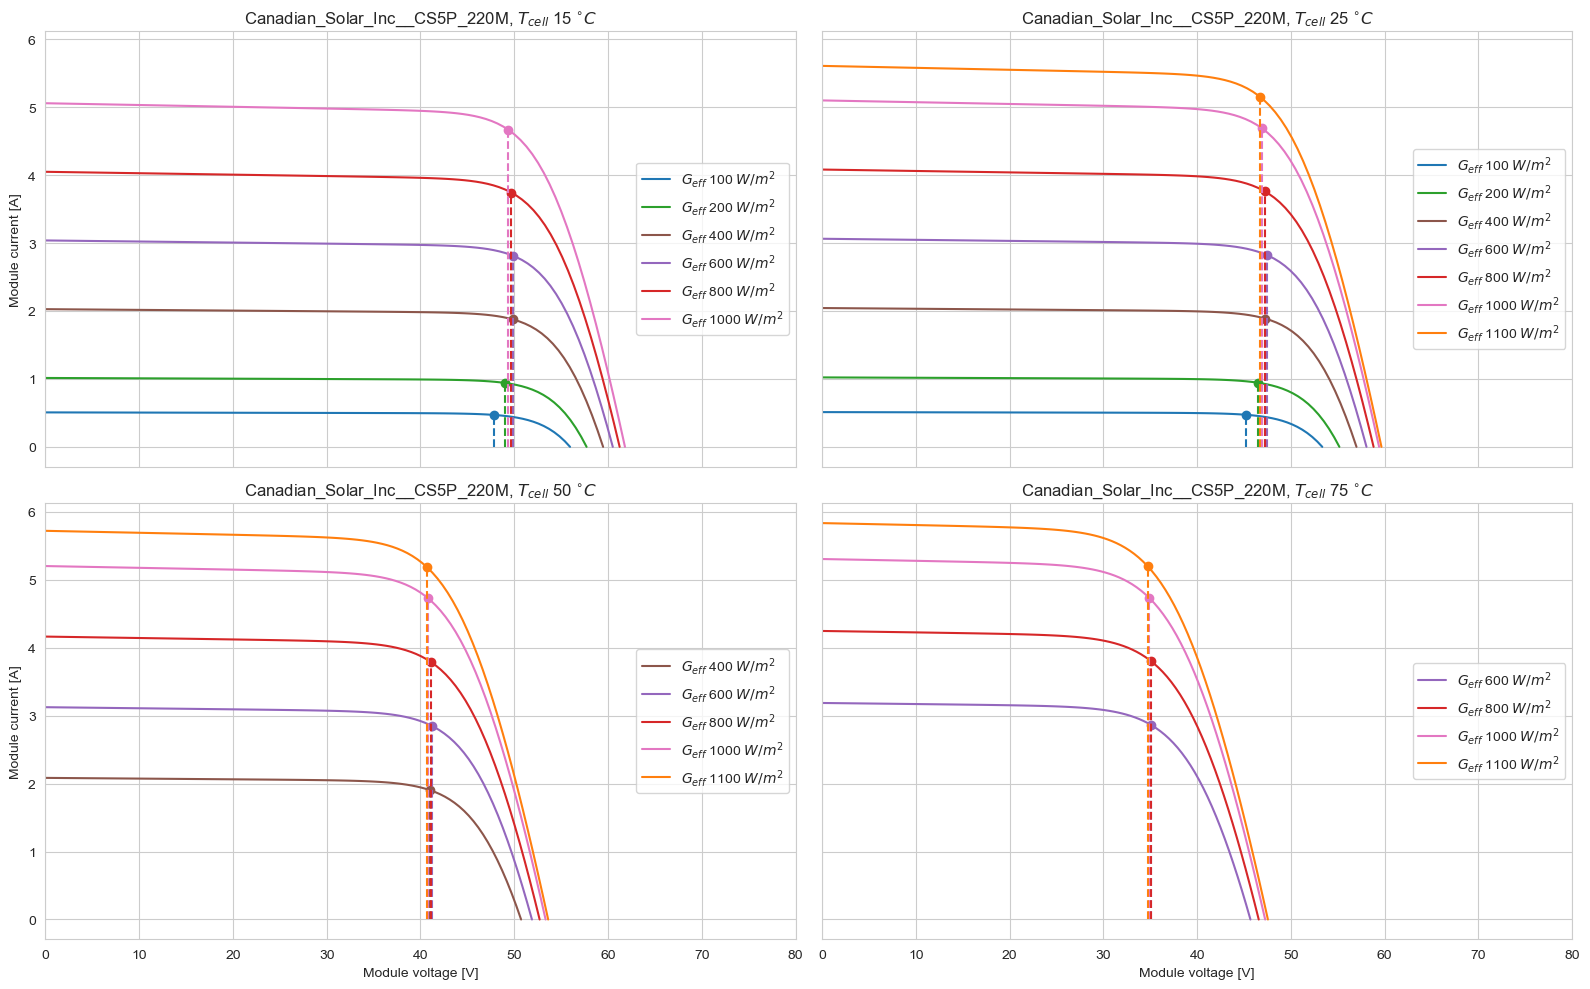

In [14]:
# построим рассчитанные кривые:
exclude = [(1100, 15), (400, 75), (200, 50), (200, 75), (100, 50), (100, 75)]
color = ['#1f77b4', '#2ca02c', '#8c564b', '#9467bd', '#d62728', '#e377c2', '#ff7f0e']
f, ax = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
for m, irr in enumerate(E_IEC61853):
    for n, tc in enumerate(T_IEC61853):
        if (irr, tc) in exclude:
            continue
        i = n + 4*m
        j = n // 2, n % 2
        label = (
                "$G_{eff}$ " + f"{irr} $W/m^2$"
        )
        ax[j].plot(curve_info['v'][i], curve_info['i'][i], label=label, c=color[m])
        v_mp = curve_info['v_mp'][i]
        i_mp = curve_info['i_mp'][i]
        # отметим точки максимальной мощности
        ax[j].plot(v_mp, i_mp, ls='', marker='o', c=color[m])
        ax[j].vlines(v_mp, 0, i_mp, linestyle='dashed', color=color[m])
        # подпишем оси, выведем легенду и название диаграммы
        ax[j].legend(loc='right')
        if j[0] == 1:
            ax[j].set_xlabel('Module voltage [V]')
        if j[1] == 0:
            ax[j].set_ylabel('Module current [A]')
        ax[j].set_title(f"{CS_220M.name}, " + "$T_{cell}$ " + f"{tc} " + "$^{\circ}C$")
        ax[j].grid(True)
        ax[j].set_xlim([0, 80])

f.tight_layout()

## Заключение
Как влияет температура и солнечная радиация на генерируемую мощность?

